<a href="https://colab.research.google.com/github/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/Project_3_Natural_Language_Processing_with_Reddit_Post.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id = 'section_0'><a/>
# 0.0 Function Creation
___

In [ ]:
# Platform Interface
import time
from time import sleep
import requests
import pickle

import pandas as pd
import numpy as np
import random
import itertools

# Visualisation Libraries
# !pip install --upgrade --quiet witwidget lime
# import lime
# import shap
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud

# ML Libraries
from nltk.tokenize import word_tokenize , sent_tokenize , RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer , TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix , plot_roc_curve , confusion_matrix
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub


pd.set_option('display.max_colwidth' , 300)

In [ ]:
def red_scrap(title):
    url = 'https://api.pushshift.io/reddit/search/submission'
    df_load = []
    params = {
        'subreddit': title,
        'size' : 100,
        'before': None
    }
    for i in range(15):
        # Access Reddit API
        res = requests.get(url,params)
        data = res.json()
        posts = data['data']
        
        
        df_new = pd.DataFrame(posts)
        df_load.append(df_new)
        
        # Initiating new time stamp (100th position of the 100 size) for before in params
        params['before'] = df_new['created_utc'][99]
        
        # Extract to CSV
        df = pd.concat(df_load, ignore_index = True)
        df.to_csv(f'{title}.csv')
        time.sleep(10)
        print(f'{i+1} Iterations completed')
        
    return df

In [ ]:
def date_conversion(df , column):

    time_value = []
    for value in df[column]:
        time_value.append(time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(value)))
        
    df[column] = time_value
    df[[column]] = df[[column]].astype('datetime64[ns]')
    return df

In [ ]:
def eval_classification(y_true , y_pred):

    from sklearn.metrics import accuracy_score , precision_score , recall_score , f1_score

    # Define Scoring variables
    accuracy = accuracy_score(y_true , y_pred)
    precision = precision_score(y_true , y_pred)
    recall = recall_score(y_true , y_pred)
    f1_score = f1_score(y_true , y_pred)

    score_dict = {'Accuracy' : accuracy,
                'Precision' : precision,
                'Recall' : recall,
                'F1 Score' : f1_score}

    return score_dict

In [ ]:
import datetime

def create_tensorboard_callback(dir_name , experiment_name):
  log_dir = dir_name +'/' + experiment_name +'/' +datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f'Saving Tensorboard log files to {log_dir}')
  return tensorboard_callback

In [ ]:
def tf_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
# df_fakenews = red_scrap('fakenews')

In [ ]:
# df_worldnews = red_scrap('worldnews')

In [ ]:
tf.config.list_physical_devices('GPU')
!nvidia-smi

Mon Sep 13 05:30:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |   4317MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<a id = 'section_1'><a/>
# 1.0 Data Exploration
___
[(back to top)](#content)

In [ ]:
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
!wget https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv

--2021-09-13 05:30:35--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/fakenews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3523846 (3.4M) [text/plain]
Saving to: ‘fakenews.csv.1’

fakenews.csv.1      100%[===================>]   3.36M  --.-KB/s    in 0.03s   

2021-09-13 05:30:35 (97.7 MB/s) - ‘fakenews.csv.1’ saved [3523846/3523846]

--2021-09-13 05:30:35--  https://raw.githubusercontent.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/main/worldnews.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP r

In [ ]:
# Fake News Reddit
df_fakenews = pd.read_csv('/content/fakenews.csv')
df_fakenews = df_fakenews[['title' , 'subreddit' , 'created_utc']]
df_fakenews = date_conversion(df_fakenews , 'created_utc')

# World News Reddit
df_worldnews = pd.read_csv('/content/worldnews.csv')
df_worldnews = df_worldnews[['title' , 'subreddit' , 'created_utc']]
df_worldnews = date_conversion(df_worldnews , 'created_utc')

In [ ]:
print(f'No. of Fakenews Datasets : {len(df_fakenews)}')
print(f'Shape of Fakenews Datasets : {df_fakenews.shape}')

print(f'No. of World News Datasets : {len(df_worldnews)}')
print(f'Shape of World News Datasets : {df_worldnews.shape}')

No. of Fakenews Datasets : 1500
Shape of Fakenews Datasets : (1500, 3)
No. of World News Datasets : 1400
Shape of World News Datasets : (1400, 3)


### 1.1 Checking for Duplicates and Null
___

In [ ]:
print(f'No. of Duplicate Cell : {df_fakenews.duplicated().sum()}')
print(f'No. of Null Cell : {df_fakenews.isnull().sum().sum()}')
df_fakenews.drop_duplicates(inplace = True)
print(f'No. of Duplicate Cell After Remove Duplicate : {df_fakenews.duplicated().sum()}')

No. of Duplicate Cell : 1
No. of Null Cell : 0
No. of Duplicate Cell After Remove Duplicate : 0


In [ ]:
print(f'No. of Duplicate Cell : {df_worldnews.duplicated().sum()}')
print(f'No. of Null Cell : {df_worldnews.isnull().sum().sum()}')

No. of Duplicate Cell : 0
No. of Null Cell : 0


### 1.2 Visualing Some Random Text
___

In [ ]:
# Visualing Some Random Post from Fake News
random_sentences = random.sample(df_fakenews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 Trump: One more time! Putin: All the colors are blurring together! Ivanka: I want that candy now!
1 Greek news trying really hard, but I guess they don't have the FX down?
2 Cnn vs fox
3 James O'Keefe live streams CNN president Jeff Zucker's 9am Call
4 FOX finally giving good advice....
5 Trump might be planning something big! Mike Lindell Martial Law document leaked and explained!
6 Can't talk about fake news to brainwashed people without this phrase:
7 .
8 Endless Curiosity: The Science of Fake News. I decided to repost this to help spread the word about misinformation!
9 Priorities USA Lies in Anti-Trump Coronavirus Ad


In [ ]:
# Visualing Some Random Post from World News
random_sentences = random.sample(df_worldnews['title'].to_list() , 10)
for index , sentence in enumerate(random_sentences):
    print(index , sentence)

0 Taliban likely to hold oath-taking ceremony on September 11: Report
1 Abimael Guzman, a maoist terrorist leader of Peru’s Shining Path dies 29 years after being captured for killing tens of thousands of Peruvians
2 indias forex reserves week by week
3 See how Microsoft is marketing Windows 11
4 Canadian Liberals' promised hike in bank taxes could lead to job cuts, higher borrowing costs
5 Malignant Review: Malignant is saved by an audacious, stunningly mounted third act
6 Austrian man mummifies dead mother to keep social security payments
7 Create and Setup Gmail Account with an Ease - Ghlatest, Insurance, Meditation, Mindset, Health, Real estate, Social media, Videos, How to, News, Amazon Product, Credit card,
8 The Orfium Project Offices / elSTUDIO
9 Former Venezuelan official, charged in narco-terrorism conspiracy, is arrested in Spain, US DOJ says


# 2.0 Data Cleaning and Preprocessing
___

In [ ]:
import nltk
import string
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

port_stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 2.1 TextVectorizer Input and Visualize Random Sentence
___

In [ ]:
'''
1. Standardize each example (usually lowercasing + punctuation stripping)
2. Split each example into substrings (usually words)
3. Recombine substrings into tokens (usually ngrams)
'''
random_sentences = random.sample(df_fakenews['title'].to_list() , 3)

for sentence in random_sentences:
    
    # Print Before Split
    print('Original Sentence                : ' , sentence)

    # Remove Numeric Number , lower words
    regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
    sent_split = regex_token.tokenize(sentence.lower())
    print('Remove Numeric , lowercase       : ' , sent_split)
    
    # Stripped the Punctuation
    sent_split = [word for word in sent_split if word not in (string.punctuation)]
    print('Remove Punctuation               : ' , sent_split)

    # Remove Stop words
    sent_split = [word for word in sent_split if word not in (stop_words)]
    print('Remove Stop words                : ' , sent_split)

    # Stem the words and joint back  
    joint = ' '.join([port_stemmer.stem(word) for word in sent_split])
    print('Stem the words & joint the words : ' , joint)
    print('-----------------------------------------')
    

Original Sentence                :  Where can I find fake news that misuse data?
Remove Numeric , lowercase       :  ['where', 'can', 'find', 'fake', 'news', 'that', 'misuse', 'data']
Remove Punctuation               :  ['where', 'can', 'find', 'fake', 'news', 'that', 'misuse', 'data']
Remove Stop words                :  ['find', 'fake', 'news', 'misuse', 'data']
Stem the words & joint the words :  find fake news misus data
-----------------------------------------
Original Sentence                :  The Artificial Racial Divide with Thomas Sowell
Remove Numeric , lowercase       :  ['the', 'artificial', 'racial', 'divide', 'with', 'thomas', 'sowell']
Remove Punctuation               :  ['the', 'artificial', 'racial', 'divide', 'with', 'thomas', 'sowell']
Remove Stop words                :  ['artificial', 'racial', 'divide', 'thomas', 'sowell']
Stem the words & joint the words :  artifici racial divid thoma sowel
-----------------------------------------
Original Sentence              

### 2.2 Preprocess Function for data
___

In [ ]:
def preprocessing(df , col):
    
    sentence_process = []
    for sentence in df[col]:
               
        # Remove Numeric Number , lower words
        regex_token = RegexpTokenizer(r'[a-zA-Z]\w+')
        sent_split = regex_token.tokenize(sentence.lower())
        
        # Stripped the Punctuation
        sent_split = [word for word in sent_split if word not in (string.punctuation)]

        # Remove Stop words
        sent_split = [word for word in sent_split if word not in (stop_words)]

        # Stem the words and joint back  
        joint = ' '.join([port_stemmer.stem(word) for word in sent_split])        
    
        sentence_process.append(joint)
    
    df[col] = sentence_process

In [ ]:
preprocessing(df_fakenews , 'title')

In [ ]:
df_fakenews.head()

,title,subreddit,created_utc
0,research show great awoken media preced trump outlast opinion,fakenews,2021-09-11 13:37:46
1,get paid china stir panic,fakenews,2021-09-10 18:52:00
2,fact check journalist spread misinform wi spa,fakenews,2021-09-10 16:25:26
3,afghani central bank governor imag goe viral real asia market,fakenews,2021-09-10 13:48:40
4,stori mike emm real,fakenews,2021-09-08 21:29:04


In [ ]:
preprocessing(df_worldnews , 'title')

In [ ]:
df_worldnews.head()

,title,subreddit,created_utc
0,mari trump say disgrac uncl spend comment box match,worldnews,2021-09-12 06:20:04
1,next fast food chicken sandwich war may fake one,worldnews,2021-09-12 06:11:44
2,revis belgium histori call first ebola outbreak congo,worldnews,2021-09-12 06:00:46
3,democrat build big edg earli vote,worldnews,2021-09-12 05:59:43
4,ch51 ch51,worldnews,2021-09-12 05:59:42


### 2.3 Removing Data Leakage
___

In [ ]:
# DF Fake News
print('Data Count Before removal leaked words:' , len(df_fakenews))
df_fakenews = df_fakenews.loc[~df_fakenews['title'].str.contains('fake|news|new|say')]
df_fakenews.head()
print('Data Count After removal leaked words:' , len(df_fakenews))

Data Count Before removal leaked words: 1499
Data Count After removal leaked words: 958


In [ ]:
print('Data Count Before removal leaked words:' , len(df_worldnews))
df_worldnews = df_worldnews.loc[~df_worldnews['title'].str.contains('world|news|new|say')]
df_worldnews.head()
print('Data Count After removal leaked words:' , len(df_worldnews))

Data Count Before removal leaked words: 1400
Data Count After removal leaked words: 1166


### 2.4 Merging Datasets
___

In [ ]:
df_main = pd.concat([df_fakenews , df_worldnews])
df_main.drop('created_utc' , inplace=True , axis = 1)

print(f'No. of Combined Datasets : {len(df_main)}')
print(f'Shape of Combined Datasets : {df_main.shape}')
print(f'SIze of Combined Datasets : {df_main.size}')

No. of Combined Datasets : 2124
Shape of Combined Datasets : (2124, 2)
SIze of Combined Datasets : 4248


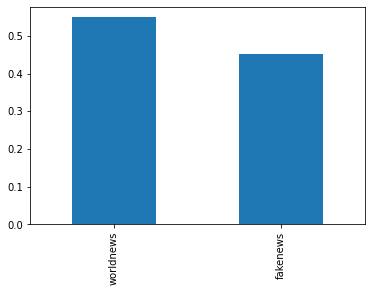

In [ ]:
df_main['subreddit'].value_counts(normalize = True).plot(kind = 'bar');

In [ ]:
dict_reddit = {'fakenews' : 0,
               'worldnews' : 1}

df_main['subreddit'] = df_main['subreddit'].map(dict_reddit)

### 2.5 Removing Sentence with only 1 word
___

In [ ]:
df_main['len of sentence'] = [len(sentence.split(' ')) for sentence in df_main['title']]

In [ ]:
print('No. of Sentence with 1 word :' , len(df_main[df_main['len of sentence'] == 1]))
print('Longest Sentence :' , df_main['len of sentence'].max())
df_main[df_main['len of sentence'] == 2].head(10)

No. of Sentence with 1 word : 136
Longest Sentence : 46


,title,subreddit,len of sentence
13,doomer propaganda,0,2
47,sam colbi,0,2
78,doomer propaganda,0,2
110,correct wrong,0,2
119,porn server,0,2
120,porn chat,0,2
123,nude server,0,2
126,lewd chat,0,2
127,girl groupchat,0,2
128,sex chat,0,2


In [ ]:
df_main = df_main[df_main['len of sentence'] > 2]

In [ ]:
# !pip install unidecode
# import unidecode

### 2.6 Visualising Popular Words
___

In [ ]:
# Inistantiating Count Vectorizer
cvec = CountVectorizer(ngram_range=(1,3))
cvec.fit(df_main['title'])
main = cvec.transform(df_main['title'])

cvec_fake = CountVectorizer(ngram_range = (1,3))
cvec_fake.fit(df_main[df_main['subreddit'] == 0]['title'])
fake = cvec_fake.transform(df_main[df_main['subreddit'] == 0]['title'])

cvec_world = CountVectorizer(ngram_range = (1,3))
cvec_world.fit(df_main[df_main['subreddit'] == 1]['title'])
world = cvec_world.transform(df_main[df_main['subreddit'] == 1]['title'])

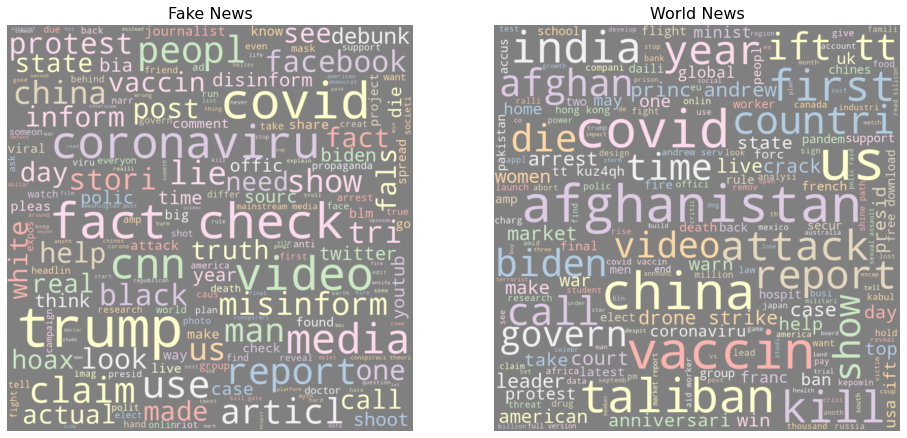

In [ ]:
# Word cloud for news

word_fake = ' '.join([word for word in df_main[df_main['subreddit'] == 0]['title']])
word_world = ' '.join([word for word in df_main[df_main['subreddit'] == 1]['title']])

wordcloud_fake = WordCloud(width= 800, 
                          height= 800,
                          max_font_size = 110,
                          collocations = True,
                          background_color = 'grey',
                          colormap= 'Pastel1').generate(word_fake)

wordcloud_world = WordCloud(width= 800, 
                            height= 800,
                            max_font_size = 110,
                            collocations = True,
                            background_color = 'grey',
                            colormap= 'Pastel1').generate(word_world)                      

plt.figure(figsize=(16,12))
plt.subplot(1,2,1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title('Fake News' , fontsize = 16)

plt.subplot(1,2,2)
plt.imshow(wordcloud_world, interpolation='bilinear')
plt.axis("off")
plt.title('World News' , fontsize = 16);

In [ ]:
# Interestingly the vocab from each DF summed up is not equal to the vocab from the merged DF
df_main_vocab = pd.DataFrame(main.todense(),
                             columns = cvec.get_feature_names())

df_fake_vocab = pd.DataFrame(fake.todense(),
                             columns = cvec_fake.get_feature_names())

df_world_vocab = pd.DataFrame(world.todense(),
                              columns = cvec_world.get_feature_names())

print(f'DF Shape for Main Vocab :' , df_main_vocab.shape)
print(f'DF Shape for fakenews Vocab  :' , df_fake_vocab.shape)
print(f'DF Shape for worldnews Vocab  :' , df_world_vocab.shape)

DF Shape for Main Vocab : (1866, 27265)
DF Shape for fakenews Vocab  : (786, 11555)
DF Shape for worldnews Vocab  : (1080, 17022)


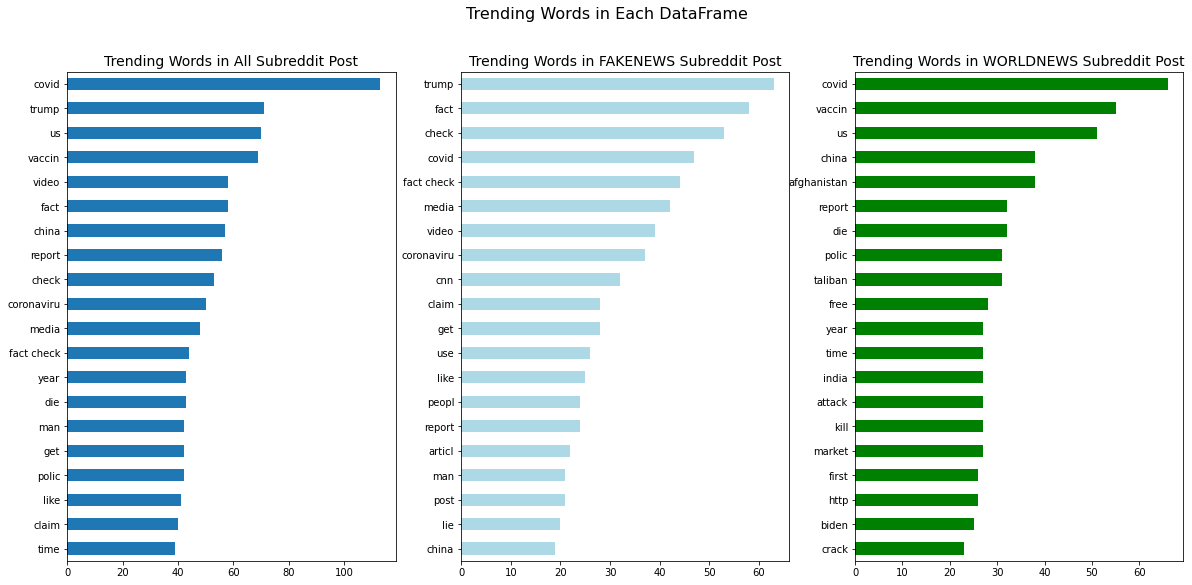

In [ ]:
fig , ax = plt.subplots(1 , 3 , figsize = (20,9))

df_main_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[0])
ax[0].set_title('Trending Words in All Subreddit Post' , fontsize = 14);

df_fake_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[1] , color = 'lightblue')
ax[1].set_title('Trending Words in FAKENEWS Subreddit Post' , fontsize = 14);

df_world_vocab.sum().sort_values(ascending = True)[-20:].plot(kind = 'barh' , ax = ax[2] , color = 'green')
ax[2].set_title('Trending Words in WORLDNEWS Subreddit Post' , fontsize = 14);

plt.suptitle('Trending Words in Each DataFrame' , fontsize = 16);

#3.0 Modelling with Random Forest

In [ ]:
X = df_main['title']
y = df_main['subreddit']

X_train , X_test , y_train , y_test = train_test_split(X , y , test_size = 0.2 ,random_state=42 , stratify = y)

print('X_train Shape : ' , X_train.shape)
print('X_test Shape : ' , X_test.shape)
print('y_train Shape : '  , y_train.shape)
print('y_test Shape : ' , y_test.shape)

X_train Shape :  (1492,)
X_test Shape :  (374,)
y_train Shape :  (1492,)
y_test Shape :  (374,)


In [ ]:
%%time
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())
])

# rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
#                  'min_samples_leaf' : np.arange(1, 5 , 1),
#                  'n_estimators' : np.arange(50 , 80 , 10),
#                  'max_features' : ['log2' , 'sqrt' , 'auto'],
#                  'max_depth' : [None , 3 , 5]}

param_grid = {'vect__ngram_range' : [(1,1) , (1,2) , (1,3)],
              'tfidf__smooth_idf' : [True , False],
              'tfidf__sublinear_tf' : [True , False],
              'model__min_samples_split' : np.arange(2 , 10 , 2),
              'model__min_samples_leaf' : np.arange(1 , 5 , 1),
              'model__n_estimators' : np.arange(50 , 80 , 10),
              'model__max_features' : ['log2' , 'sqrt' , 'auto'],
              'model__max_depth' : [3,5,7]              
}

# Fitting the model
model = GridSearchCV(estimator = pipe,
                     param_grid = param_grid,
                     cv = 5,
                     n_jobs =-1)

model.fit(X_train , y_train)
# # Model Prediction
y_pred = model.predict(X_test)

CPU times: user 4min 26s, sys: 8.77 s, total: 4min 34s
Wall time: 1h 6min 31s


In [ ]:
model.best_params_

{'model__max_depth': 7,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 4,
 'model__min_samples_split': 6,
 'model__n_estimators': 70,
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'vect__ngram_range': (1, 1)}

In [ ]:
# Saving the Model
pickle.dump(model , open('RFC_model.pkl' , 'wb'))

In [ ]:
# !wget https://github.com/86lekwenshiung/Natural-Language-Processing-with-Reddit-Post/blob/main/saved_models/RFC_model.pkl

### 3.0.5 Experimenting with New GridSearch parameters
___

In [ ]:
%%time
pipe = Pipeline([('vect', CountVectorizer(min_df = 0.01 , max_df = 0.9)),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())
])

# rf_param_grid = {'min_samples_split' : np.arange(2 , 10 , 2),
#                  'min_samples_leaf' : np.arange(1, 5 , 1),
#                  'n_estimators' : np.arange(50 , 80 , 10),
#                  'max_features' : ['log2' , 'sqrt' , 'auto'],
#                  'max_depth' : [None , 3 , 5]}

param_grid = {'vect__min_df' : range(5,10),
              'model__min_samples_split' : np.arange(1 , 5 , 1),
              'model__min_samples_leaf' : np.arange(6 , 8 , 1),
              'model__n_estimators' : np.arange(90 , 120 , 10),
              'model__max_features' : ['sqrt'],
              'model__max_depth' : [None]              
}

# Fitting the model
model_2 = GridSearchCV(estimator = pipe,
                       param_grid = param_grid,
                       cv = 5,
                       n_jobs =-1)

model_2.fit(X_train , y_train)
# # Model Prediction
y_pred_2 = model_2.predict(X_test)

CPU times: user 10.9 s, sys: 408 ms, total: 11.3 s
Wall time: 3min 11s


In [ ]:
model_2.best_params_

{'model__max_depth': None,
 'model__max_features': 'sqrt',
 'model__min_samples_leaf': 6,
 'model__min_samples_split': 4,
 'model__n_estimators': 100,
 'vect__min_df': 8}

In [ ]:
model_RFC = Pipeline([('vect', CountVectorizer(min_df = 8 , max_df = 1.0 , ngram_range = (1,1))),
                      ('tfidf', TfidfTransformer('l2')),
                      ('model', RandomForestClassifier(min_samples_split=4,
                                                       min_samples_leaf = 6,
                                                       n_estimators = 100,
                                                       max_features = 'sqrt'))
])
                      
model_RFC.fit(X_train , y_train)
model_RFC_pred = model_RFC.predict(X_test)

{'Accuracy': 0.7647058823529411,
 'F1 Score': 0.8174273858921162,
 'Precision': 0.7406015037593985,
 'Recall': 0.9120370370370371}

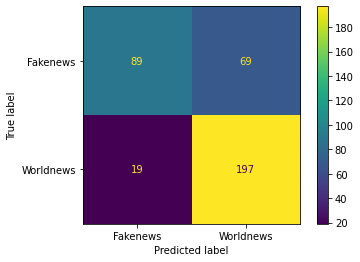

In [ ]:
plot_confusion_matrix(model_RFC , X_test , 
                      y_test , 
                      values_format = '.4g',
                      display_labels = ['Fakenews' , 'Worldnews']);

eval_classification(y_true=y_test , y_pred = model_RFC_pred)

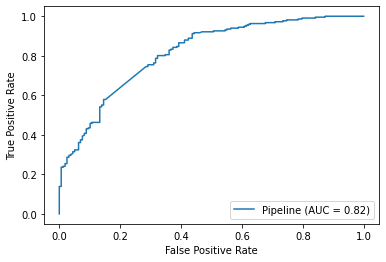

In [ ]:
plot_roc_curve(model_RFC , X_test , y_test)

### 3.1 Evaluating Model Score
___

In [ ]:
eval_classification(y_true=y_test , y_pred = y_pred)

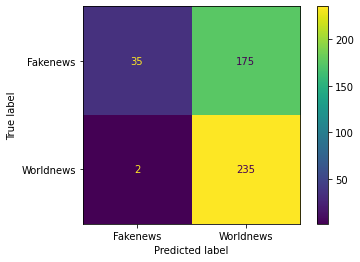

In [ ]:
plot_confusion_matrix(model , X_test , 
                      y_test , 
                      values_format = '.4g',
                      display_labels = ['Fakenews' , 'Worldnews']);

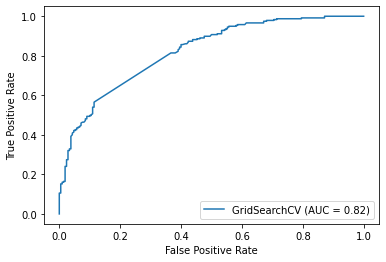

In [ ]:
plot_roc_curve(model , X_test , y_test)

### 3.2 Visualing Most Wrongly Predicted Reddit Post
___

In [ ]:
y_proba = model_RFC.predict_proba(X_test)
fakenews_prediction = [y_proba[i][0] for i in range(len(X_test))]

In [ ]:
df_prediction  = pd.DataFrame({'Title' : X_test,
                              'Target' : y_test,
                              'Prediction' : model_RFC_pred,
                              'Fakenews_prediction' : fakenews_prediction})

In [ ]:
# Visualing Most Wrong Fake News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Fakenews_prediction' , ascending = False)
df_most_right_wrong.tail(10)

,Title,Target,Prediction,Fakenews_prediction
780,instagram girl accus cv la habra falsifi covid result,0,1,0.263834
809,bu keng statement rappler ceo blame ph govern cyber libel case,0,1,0.263430
751,polic seiz rifl st loui coupl film wave gun blm protest,0,1,0.260509
1486,misconcept cast system india,0,1,0.258962
732,loss word unravel narr behind atlant defund polic shoot tale,0,1,0.253596
462,hate year old sometim,0,1,0.247888
717,china put econom sanction us swear enforc global,0,1,0.236423
1334,suprem court su suprem,0,1,0.225619
373,due covid travel restrict american forc hold coup local year,0,1,0.210580
261,pocahonta first winner hunger game,0,1,0.147431


In [ ]:
# Visualing Most Wrong World News

df_most_right_wrong = df_prediction[df_prediction['Target'] != df_prediction['Prediction']].sort_values(by = 'Fakenews_prediction' , ascending = False)
df_most_right_wrong.head(10)

,Title,Target,Prediction,Fakenews_prediction
36,ttp warn pakistani media ask refrain call terrorist dawn,1,0,0.899976
1286,mari trump rip fascist uncl assum even know mean,1,0,0.846832
41,cnn jake tapper attack joe biden scold unvaccin,1,0,0.834092
1398,trump gripe lose ungrat cathol jewish voter call religi advis,1,0,0.828658
1069,pakistan report fresh coronaviru case death,1,0,0.786407
313,bjp led goa govt claim pc covid vaccin addit pack lie digambar kamat former chief minist goa digambar kamat saturday slam bjp led goa govern said claim per cent covid vaccin anoth addit pack lie,1,0,0.775447
529,republican alreadi lie california recal elect rig,1,0,0.771611
1346,facebook apolog put primat label video black men,1,0,0.745209
1160,look beauti taj mahal taj mahal video video clip,1,0,0.701430
1174,rep ocasio cortez give gov greg abbott biolog lesson disgust rape claim,1,0,0.697782


# 4.0 Modelling with TF Universal Encoder
___

`turning data into numbers (textvectorisation , embedding)` -> `building a model` -> `training the model`

In [ ]:
max_vocab_length = 6000 # We have around 4848 from above visualisation
max_length = 30

text_vectorisation = TextVectorization(max_tokens = max_vocab_length,
                                       output_mode = 'int',
                                       output_sequence_length = None,
                                       pad_to_max_tokens = True)

In [ ]:
embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [ ]:
random_sentences = random.sample(df_main['title'].to_list() , 3)

for sentence in random_sentences:
  print(sentence)
  print(embed([sentence]))
  print('------------------------------------------------')

familymart prep unman store japan
tf.Tensor(
[[ 1.1086745e-02  4.4888739e-02  2.9582803e-03  1.0734531e-02
  -1.7443817e-02  6.6441894e-02  4.6857182e-02  1.8843513e-02
  -5.8886938e-02 -4.8072208e-02 -4.1830320e-02 -4.9854625e-02
  -7.5100148e-03 -8.7788500e-02  1.0463382e-02  1.8261025e-02
   6.3444830e-02 -2.6153125e-02  2.0142049e-03 -5.7530627e-02
   7.9016283e-02 -1.1477780e-02 -6.1740678e-02 -7.3008843e-02
   4.8024088e-02 -4.8998244e-02 -3.6688361e-02  4.6531551e-02
  -2.9152319e-02 -1.5487598e-02  8.1795245e-02 -2.5554096e-02
   6.7295447e-02 -7.3847370e-03 -1.7972359e-02  3.0913712e-02
  -2.5199126e-03 -5.3023104e-02 -1.5747946e-02 -7.5156175e-02
   9.2985623e-02 -2.4585648e-02  5.7140812e-02 -5.1563643e-02
  -1.9636971e-03  2.0505885e-02 -9.7724590e-03  1.5822425e-02
  -8.7785654e-02  6.0821254e-02  2.8582085e-02  4.4781543e-02
   3.6951096e-03 -6.7834020e-02  7.9114437e-02 -1.1085910e-02
   7.7203892e-02 -2.4568915e-02  6.7722902e-02 -3.9968789e-02
  -7.2359778e-03  4.39340

In [ ]:
# Create a Keras Layer using Universal Sentence Encoder
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = 'tf_model')

In [ ]:
tf_model = tf.keras.Sequential([
                               sentence_encoder_layer,
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(64 , activation = 'relu'),
                               layers.Dense(1 , activation = 'sigmoid')
])

tf_model.compile(optimizer = tf.keras.optimizers.Adam(),
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics = 'accuracy')

In [ ]:
tf_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tf_model (KerasLayer)        (None, 512)               256797824 
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 256,834,881
Trainable params: 37,057
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_tf = tf_model.fit(X_train,
                         y_train,
                         epochs = 5,
                         validation_data = (X_test , y_test),
                         callbacks = [create_tensorboard_callback('model_log' , 'tf_model')])

Saving Tensorboard log files to model_log/tf_model/20210913-053306
Epoch 1/5
47/47 [==============================] - 7s 89ms/step - loss: 0.6408 - accuracy: 0.6287 - val_loss: 0.5475 - val_accuracy: 0.7620
Epoch 2/5
47/47 [==============================] - 1s 21ms/step - loss: 0.4748 - accuracy: 0.8043 - val_loss: 0.4196 - val_accuracy: 0.8209
Epoch 3/5
47/47 [==============================] - 1s 19ms/step - loss: 0.3990 - accuracy: 0.8304 - val_loss: 0.4206 - val_accuracy: 0.8182
Epoch 4/5
47/47 [==============================] - 1s 22ms/step - loss: 0.3577 - accuracy: 0.8499 - val_loss: 0.4264 - val_accuracy: 0.8182
Epoch 5/5
47/47 [==============================] - 1s 18ms/step - loss: 0.3240 - accuracy: 0.8673 - val_loss: 0.4363 - val_accuracy: 0.8128


In [ ]:
tf_model_pred = tf_model.predict(X_test)

In [ ]:
eval_classification(y_test , tf.squeeze(tf.round(tf_model_pred)))

{'Accuracy': 0.8128342245989305,
 'F1 Score': 0.8416289592760181,
 'Precision': 0.8230088495575221,
 'Recall': 0.8611111111111112}

Confusion matrix, without normalization
[[118  40]
 [ 30 186]]


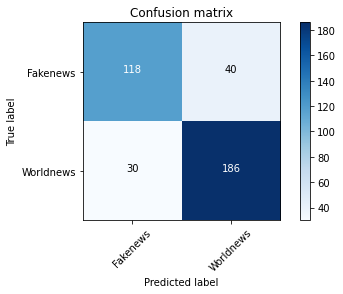

In [ ]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(tf_model_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

# 5.0 LSTM Model
___

In [ ]:
max_vocab_length = 6000  # Max number of words in our vocab
max_length = 30 # max length our sequence will be (In this case the sequence is a tweet)

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length,
                                    pad_to_max_tokens = True)

text_vectorizer.adapt(X_train) # so your text vectorization will create a vocab.


embedding = tf.keras.layers.Embedding(input_dim = max_vocab_length,
                                      output_dim = 128,
                                      input_length = max_length)

inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64 , return_sequences = True))(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(32))(x)
print(x.shape)
outputs = layers.Dense(1 , activation = 'sigmoid')(x)
print(x.shape)

lstm_model = tf.keras.Model(inputs , outputs , name = 'lstm_bidrection')

(None, 30, 128)
(None, 30, 128)
(None, 64)
(None, 64)


In [ ]:
lstm_model.summary()

Model: "lstm_bidrection"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_5 (TextVe (None, 30)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 30, 128)           768000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 30, 128)           98816     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 908,097
Trainable params: 908,097
Non-trainable params: 0
_____________________________________________

In [ ]:
lstm_model.compile(optimizer = tf.keras.optimizers.Adam(),
                   loss = tf.keras.losses.BinaryCrossentropy(),
                   metrics = 'accuracy')

In [ ]:
history_lstm = lstm_model.fit(X_train,
                              y_train,
                              epochs = 5,
                              validation_data = (X_test , y_test),
                              callbacks = [create_tensorboard_callback('model_log' , 'lstm_model')])

Saving Tensorboard log files to model_log/lstm_model/20210913-053356
Epoch 1/5
47/47 [==============================] - 12s 112ms/step - loss: 0.6325 - accuracy: 0.6327 - val_loss: 0.4608 - val_accuracy: 0.7914
Epoch 2/5
47/47 [==============================] - 2s 44ms/step - loss: 0.2156 - accuracy: 0.9290 - val_loss: 0.4569 - val_accuracy: 0.8102
Epoch 3/5
47/47 [==============================] - 2s 40ms/step - loss: 0.0681 - accuracy: 0.9839 - val_loss: 0.6763 - val_accuracy: 0.8048
Epoch 4/5
47/47 [==============================] - 2s 40ms/step - loss: 0.0244 - accuracy: 0.9953 - val_loss: 0.7142 - val_accuracy: 0.7861
Epoch 5/5
47/47 [==============================] - 2s 44ms/step - loss: 0.0163 - accuracy: 0.9966 - val_loss: 0.8179 - val_accuracy: 0.7861


In [ ]:
lstm_model_pred = lstm_model.predict(X_test)

In [ ]:
eval_classification(y_test , tf.squeeze(tf.round(lstm_model_pred)))

{'Accuracy': 0.786096256684492,
 'F1 Score': 0.8305084745762712,
 'Precision': 0.765625,
 'Recall': 0.9074074074074074}

Confusion matrix, without normalization
[[ 98  60]
 [ 20 196]]


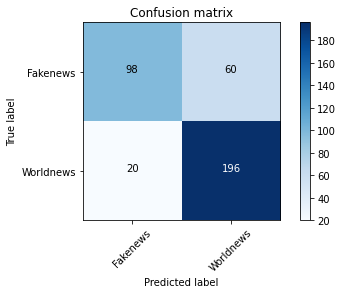

In [ ]:
cm = confusion_matrix(y_test , tf.squeeze(tf.round(lstm_model_pred)))

tf_confusion_matrix(cm = cm , classes=['Fakenews' , 'Worldnews']);

In [ ]:
words_in_vocab = text_vectorizer.get_vocabulary()
words_in_vocab[:10]

['',
 '[UNK]',
 'covid',
 'us',
 'trump',
 'vaccin',
 'fact',
 'china',
 'coronaviru',
 'video']

In [ ]:
# Get the weight matrix of embedding layer
# (these are the numerical representation of each token in our training data)
# For every unique token or vocab , there is 128 vectors representing it.
embed_weights = lstm_model.get_layer('embedding_3').get_weights()[0]
embed_weights.shape

(6000, 128)

In [ ]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0: 
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>